<a href="https://colab.research.google.com/github/srivathsa26/email-analysis/blob/main/code%20main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Open Rate: 10.35%
Click-Through Rate: 2.12%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19547
           1       0.07      0.01      0.02       453

    accuracy                           0.97     20000
   macro avg       0.52      0.50      0.50     20000
weighted avg       0.96      0.97      0.97     20000

ROC AUC: 0.5864038462342024

Simulated CTR for Top 50%: 3.90%
Original CTR: 2.12%
Estimated Improvement: 1.78%

CTR by Country:
 user_country
UK    0.024675
US    0.024360
ES    0.008327
FR    0.008004
Name: clicked, dtype: float64

CTR by Email Version:
 email_version
generic         0.015137
personalized    0.027294
Name: clicked, dtype: float64


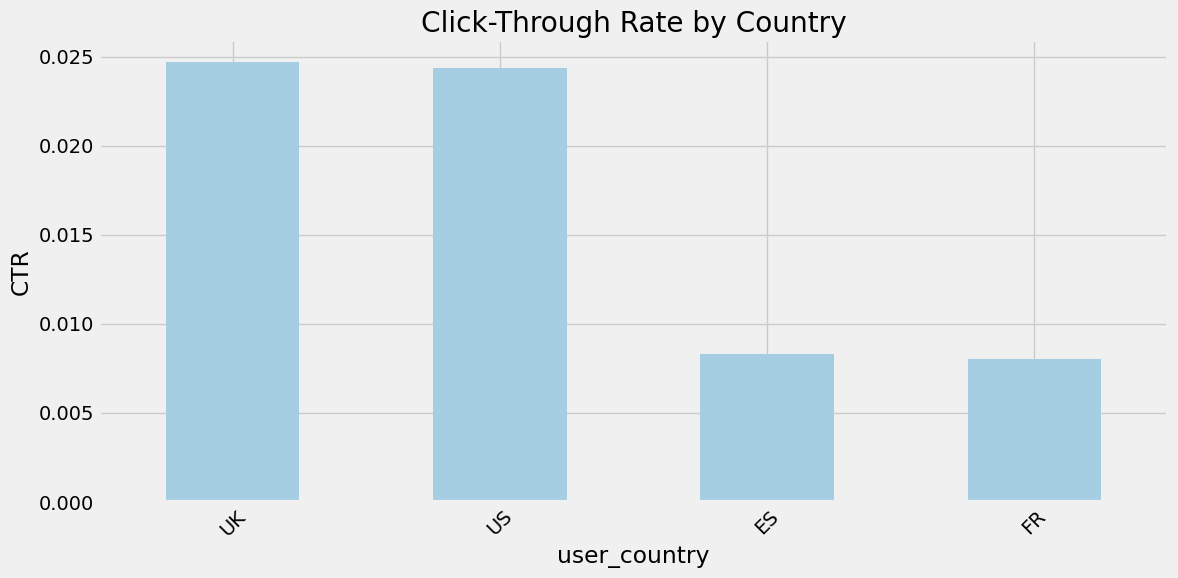


Simulated CTR with Uplift Targeting: 2.74%
Original CTR (random): 2.12%

CTR by Uplift Bucket:
 uplift_bucket
Low          0.010262
Medium       0.020396
High         0.026233
Very High    0.037352
Name: clicked, dtype: float64


<ipython-input-5-d97188d25545>:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_ctr = df_uplift.groupby('uplift_bucket')['clicked'].mean()


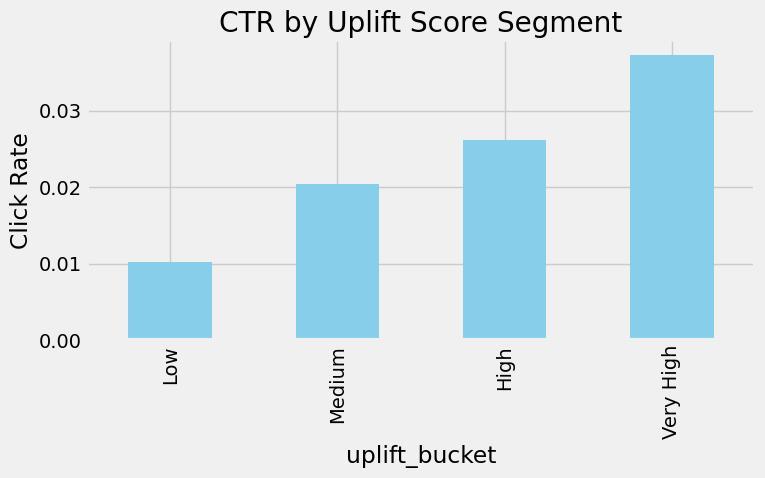

In [ ]:
# 📦 Step 1: Load Libraries and Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Install uplift modeling library
!pip install causalml -q
from causalml.inference.tree import UpliftTreeClassifier

# Load data
email_df = pd.read_csv("/content/drive/MyDrive/email (1)/email_table.csv")
opened_df = pd.read_csv("/content/drive/MyDrive/email (1)/email_opened_table.csv")
clicked_df = pd.read_csv("/content/drive/MyDrive/email (1)/link_clicked_table.csv")

# 📊 Step 2: Basic Campaign Metrics
total_emails = email_df.shape[0]
num_opened = opened_df['email_id'].nunique()
num_clicked = clicked_df['email_id'].nunique()

open_rate = num_opened / total_emails
click_through_rate = num_clicked / total_emails

print(f"Open Rate: {open_rate:.2%}")
print(f"Click-Through Rate: {click_through_rate:.2%}")

# 🧩 Step 3: Data Preparation
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

# 🎯 Step 4: Predictive Modeling (Click Prediction)
X = email_df[['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']]
y = email_df['clicked']

categorical_features = ['email_text', 'email_version', 'weekday', 'user_country']
numeric_features = ['hour', 'user_past_purchases']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# 🔍 Step 5: Model Evaluation
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 📈 Step 6: Simulate Targeting by Click Probability
email_df['click_proba'] = pipeline.predict_proba(X)[:, 1]
email_df_sorted = email_df.sort_values(by='click_proba', ascending=False)
top_50_pct = email_df_sorted.head(int(0.5 * total_emails))
simulated_ctr = top_50_pct['clicked'].sum() / top_50_pct.shape[0]

print(f"\nSimulated CTR for Top 50%: {simulated_ctr:.2%}")
print(f"Original CTR: {click_through_rate:.2%}")
print(f"Estimated Improvement: {simulated_ctr - click_through_rate:.2%}")

# 🔎 Step 7: Segment Analysis
ctr_by_country = email_df.groupby('user_country')['clicked'].mean().sort_values(ascending=False)
print("\nCTR by Country:\n", ctr_by_country)

ctr_by_version = email_df.groupby('email_version')['clicked'].mean()
print("\nCTR by Email Version:\n", ctr_by_version)

plt.figure(figsize=(12, 6))
ctr_by_country.plot(kind='bar')
plt.title('Click-Through Rate by Country')
plt.ylabel('CTR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 🌟 Step 8: Uplift Modeling for Smart Targeting

# Step 8.1: Simulate treatment assignment (50/50)
df_uplift = email_df.copy()
df_uplift['treatment'] = np.random.binomial(1, 0.5, size=len(df_uplift))
df_uplift['outcome'] = df_uplift['clicked']

# Step 8.2: Feature encoding
features = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
df_model = df_uplift[features + ['treatment', 'outcome']].copy()

df_model = pd.get_dummies(df_model, columns=['email_text', 'email_version', 'weekday', 'user_country'], drop_first=True)

# Step 8.3: 🔧 Fix Treatment Type Mismatch — Convert treatment to string
df_model['treatment'] = df_model['treatment'].astype(str)
df_model['outcome'] = df_model['outcome'].astype(int)

# Step 8.4: Prepare data for uplift model
X_uplift = df_model.drop(['treatment', 'outcome'], axis=1).astype(float).values
treatment = df_model['treatment'].values  # string labels: '0' or '1'
y_uplift = df_model['outcome'].values     # binary: 0 or 1

# Fit the uplift model
uplift_model = UpliftTreeClassifier(control_name='0', max_depth=5, min_samples_leaf=100)
uplift_model.fit(X=X_uplift, treatment=treatment, y=y_uplift)

# Predict outcomes under treatment and control
uplift_preds = uplift_model.predict(X_uplift)

# Compute uplift score: treatment - control
df_uplift['uplift_score'] = uplift_preds[:, 1] - uplift_preds[:, 0]

# Rank and simulate targeting
df_uplift_sorted = df_uplift.sort_values(by='uplift_score', ascending=False)
top_50_uplift = df_uplift_sorted.head(int(0.5 * len(df_uplift)))
simulated_uplift_ctr = top_50_uplift['clicked'].sum() / top_50_uplift.shape[0]

print(f"\nSimulated CTR with Uplift Targeting: {simulated_uplift_ctr:.2%}")
print(f"Original CTR (random): {click_through_rate:.2%}")

# Visualize uplift buckets
df_uplift['uplift_bucket'] = pd.qcut(df_uplift['uplift_score'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
segment_ctr = df_uplift.groupby('uplift_bucket')['clicked'].mean()
print("\nCTR by Uplift Bucket:\n", segment_ctr)

plt.figure(figsize=(8, 5))
segment_ctr.plot(kind='bar', color='skyblue')
plt.title('CTR by Uplift Score Segment')
plt.ylabel('Click Rate')
plt.tight_layout()
plt.show()
